In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import tqdm
from tqdm import trange
import torch
from torch import nn, optim
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
# Read the data
train = pd.read_csv('memes_train.csv')
test = pd.read_csv('memes_test.csv')
print('training dataset: ', train.shape)
print('testing dataset: ', test.shape)

training dataset:  (6625, 10)
testing dataset:  (1657, 10)


In [4]:
# Load the model
from transformers import ViltProcessor, ViltModel
from PIL import Image
import requests

processor = ViltProcessor.from_pretrained("dandelin/vilt-b32-finetuned-vqa")
model = ViltModel.from_pretrained("dandelin/vilt-b32-finetuned-vqa")

Some weights of the model checkpoint at dandelin/vilt-b32-finetuned-vqa were not used when initializing ViltModel: ['classifier.1.bias', 'classifier.1.weight', 'classifier.3.weight', 'classifier.0.bias', 'classifier.3.bias', 'classifier.0.weight']
- This IS expected if you are initializing ViltModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViltModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# use cuda if available
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# define the classifier
model = model.to(device)
encoder = nn.Sequential(*[model.embeddings, model.encoder])
ViT_embed_dim = 768  # final embedding dimension for ViT
n_classes = 2        # number of classes for my dataset
classifier = nn.Linear(ViT_embed_dim, n_classes)

In [7]:
# prepare the dataloader
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.transforms import ToTensor
from PIL import Image
import requests

class MemeDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # read the data from the dataframe
        row = self.df.iloc[idx]
        image = row['image_path']
        # image = Image.open(image).convert('RGB')
        if self.transform:
            image = Image.open(image).convert('RGB')
            image = self.transform(image)        
        text = str(row['image_text'])
        # date = row['created_at']
        label = row['label']

        return image, text, label

# define transforms
transform = {
        'train' : transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.RandomRotation(50),
                                      transforms.ToTensor()]),

        'valid' : transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.ToTensor()])
        }


In [8]:
# splite the training set into train and valid
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=42)
print('training dataset: ', train_df.shape)
print('validation dataset: ', valid_df.shape)

training dataset:  (5300, 10)
validation dataset:  (1325, 10)


In [9]:
# load the dataset
train_dataset = MemeDataset(train_df)
valid_dataset = MemeDataset(valid_df)
test_dataset = MemeDataset(test)

In [10]:
# define the dataloader
batch_size = 64
num_workers = 3
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

In [26]:
# define the fine-tune function
def fine_tune_ViT(encoder,     # ViT encoder (pre-trained)
                  classifier,  # single-layer fully-connected classifier
                  dataloaders, # dict with 2 keys, "train" and "valid", containing train & valid dataloaders
                  n_epochs,    # number of epochs to fine-tune
                  lr,          # learning rate
                  multi_label_data=False
                  ):
  
  encoder.to(device)
  classifier.to(device)

  #  1. Define optimizers and loss function  
  optimizer_encoder = optim.Adam(encoder.parameters(), lr=lr, betas=(0.5, 0.9))
  optimizer_classifier = optim.Adam(classifier.parameters(), lr=lr, betas=(0.5, 0.9))
  ### Different loss criterion for multi-label and single-label data
  if multi_label_data:
    criterion = nn.BCEWithLogitsLoss().to(device)
  else: # single-label data (standard)
    criterion = nn.CrossEntropyLoss().to(device)
  
  train_losses, val_losses, val_accs = [], [], []
  for e in trange(n_epochs, desc="Epoch"):
    #  2. Train on training data  
    encoder.train()
    classifier.train()
    train_loss = 0.
    for batch_i, (image, text, label) in enumerate(train_loader):
      # image = Image.open(requests.get(img, stream=True).raw)
      # image = Image.open(img)
      images = []
      for img in image:
        images.append(Image.open(img).convert('RGB'))
      # texts = []
      # for txt in text:
      #   texts.append(txt)
      inputs = processor(images, text, return_tensors="pt", padding=True, truncation=True).to(device)
      outputs = model(**inputs)
      logits = classifier(outputs.pooler_output) #get the predictions 
           
      optimizer_encoder.zero_grad()
      optimizer_classifier.zero_grad()

      label = label.to(device)
      if multi_label_data:
        loss = criterion(logits.type(torch.FloatTensor), label.type(torch.FloatTensor))
      else:
        loss = criterion(logits.squeeze(-1).to(device), label)

      loss.backward()
      optimizer_encoder.step()
      optimizer_classifier.step()
      train_loss += loss.item()
      # print(f"For batch {batch_i+1}/{len(train_loader)}.. "
      #       f"Train loss: {loss.item():.3f}.. ")
    train_losses.append(train_loss/len(train_loader))
    print(f"Epoch {e+1}/{n_epochs}.. "
          f"Train loss: {train_loss/len(train_loader):.3f}.. ") 
    

    #  3. Evaluate on valdiation data  
    encoder.eval()
    classifier.eval()
    val_loss = 0.
    for batch_i, (val_image, val_text, val_label) in enumerate(valid_loader):
      # image = Image.open(img)
      val_images = []
      for img in val_image:
        val_images.append(Image.open(img).convert('RGB'))
      # texts = []
      # for txt in text:
      #   texts.append(txt)
      inputs = processor(val_images, val_text, return_tensors="pt", padding=True, truncation=True).to(device)
      val_label = val_label.to(device)
      with torch.no_grad():
        # embeddings, att_weights = encoder(img) # embeddings: [batch_size, n_tokens, embedding dim]
        outputs = model(**inputs)
        logits = classifier(outputs.pooler_output) #get the predictions
        # loss = criterion(logits.type(torch.FloatTensor), label.type(torch.FloatTensor))
        loss = criterion(logits.squeeze(-1).to(device), val_label)
        val_loss += loss.item()
    
    #  4. Log results and save model checkpoints 
    print("Epoch: {}/{}   Val CE Loss: {:.5f}".format(e+1, n_epochs, val_loss/len(valid_loader)))
    
    # torch.save(encoder.state_dict(), 'encoder_{}.pt'.format(e+1))
    # torch.save(classifier.state_dict(), 'classifier_{}.pt'.format(e+1))
    # # save the best model
    if val_loss/len(valid_loader) < min(val_losses):
      torch.save(encoder.state_dict(), 'best_encoder.pt')
      torch.save(classifier.state_dict(), 'best_classifier.pt')
    val_losses.append(val_loss/len(valid_loader))

  return encoder, classifier

In [27]:
# fine-tune the model
encoder, classifier = fine_tune_ViT(encoder, 
                                    classifier, 
                                    n_epochs=10, 
                                    lr=3e-6,
                                    dataloaders={'train': train_loader, 'valid': valid_loader}
                                    )

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10.. Train loss: 0.628.. 


Epoch:  10%|█         | 1/10 [02:16<20:28, 136.46s/it]

Epoch: 1/10   Val CE Loss: 0.64861
Epoch 2/10.. Train loss: 0.595.. 


Epoch:  20%|██        | 2/10 [04:33<18:16, 137.04s/it]

Epoch: 2/10   Val CE Loss: 0.63753
Epoch 3/10.. Train loss: 0.560.. 


Epoch:  30%|███       | 3/10 [06:51<16:00, 137.21s/it]

Epoch: 3/10   Val CE Loss: 0.63731
Epoch 4/10.. Train loss: 0.523.. 


Epoch:  40%|████      | 4/10 [09:10<13:48, 138.04s/it]

Epoch: 4/10   Val CE Loss: 0.62701
Epoch 5/10.. Train loss: 0.483.. 


Epoch:  50%|█████     | 5/10 [11:29<11:31, 138.23s/it]

Epoch: 5/10   Val CE Loss: 0.62605
Epoch 6/10.. Train loss: 0.440.. 


Epoch:  60%|██████    | 6/10 [13:48<09:14, 138.53s/it]

Epoch: 6/10   Val CE Loss: 0.62782
Epoch 7/10.. Train loss: 0.395.. 


Epoch:  70%|███████   | 7/10 [16:05<06:54, 138.25s/it]

Epoch: 7/10   Val CE Loss: 0.63517
Epoch 8/10.. Train loss: 0.348.. 


Epoch:  80%|████████  | 8/10 [18:23<04:36, 138.08s/it]

Epoch: 8/10   Val CE Loss: 0.64617
Epoch 9/10.. Train loss: 0.299.. 


Epoch:  90%|█████████ | 9/10 [20:41<02:17, 137.98s/it]

Epoch: 9/10   Val CE Loss: 0.66066
Epoch 10/10.. Train loss: 0.251.. 


Epoch: 100%|██████████| 10/10 [22:58<00:00, 137.90s/it]

Epoch: 10/10   Val CE Loss: 0.67779


In [ ]:
# # load the best model
encoder.load_state_dict(torch.load('best_encoder.pt'))
classifier.load_state_dict(torch.load('best_classifier.pt'))

In [63]:
# plot the roc curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

tp, fp, tn, fn = 0, 0, 0, 0
y_true = []
y_pred = []
for batch_i, (test_image, test_text, test_label) in enumerate(test_loader):
    # image = Image.open(img)
    test_images = []
    for img in test_image:
        test_images.append(Image.open(img).convert('RGB'))
    inputs = processor(test_images, test_text, return_tensors="pt", padding=True, truncation=True).to(device)
    test_label = test_label.to(device)
    with torch.no_grad():
        # embeddings, att_weights = encoder(img) # embeddings: [batch_size, n_tokens, embedding dim]
        outputs = model(**inputs)
        logits = classifier(outputs.pooler_output) #get the predictions
        # generate predictions
        preds = torch.argmax(logits, dim=1)
        # print(preds)
        # print(test_label)
        print('The number of correct predictions: ', (preds == test_label).sum().item(), '/', len(preds))

        # test the model
encoder.eval()
classifier.eval()
test_loss = 0.
tp, tn, fp, fn = 0, 0, 0, 0

for batch_i, (test_image, test_text, test_label) in enumerate(test_loader):
    # image = Image.open(img)
    test_images = []
    for img in test_image:
        test_images.append(Image.open(img).convert('RGB'))
    inputs = processor(test_images, test_text, return_tensors="pt", padding=True, truncation=True).to(device)
    test_label = test_label.to(device)
    with torch.no_grad():
        # embeddings, att_weights = encoder(img) # embeddings: [batch_size, n_tokens, embedding dim]
        outputs = model(**inputs)
        logits = classifier(outputs.pooler_output) #get the predictions
        # generate predictions
        preds = torch.argmax(logits, dim=1)
        # print(preds)
        # print(test_label)
        print('The number of correct predictions: ', (preds == test_label).sum().item(), '/', len(preds))
        
    # get the accuracy
    for i in range(len(preds)):
        if preds[i] == 1 and test_label[i] == 1:
            tp += 1
        elif preds[i] == 0 and test_label[i] == 0:
            tn += 1
        elif preds[i] == 1 and test_label[i] == 0:
            fp += 1
        else:
            fn += 1   
    
    for i in range(len(preds)):
        y_true.append(test_label[i].item())
        y_pred.append(preds[i].item())

fpr, tpr, thresholds = roc_curve(y_true, y_pred)

The number of correct predictions:  38 / 64
The number of correct predictions:  44 / 64
The number of correct predictions:  47 / 64
The number of correct predictions:  41 / 64
The number of correct predictions:  43 / 64
The number of correct predictions:  45 / 64
The number of correct predictions:  40 / 64
The number of correct predictions:  43 / 64
The number of correct predictions:  41 / 64
The number of correct predictions:  46 / 64
The number of correct predictions:  44 / 64
The number of correct predictions:  40 / 64
The number of correct predictions:  42 / 64
The number of correct predictions:  42 / 64
The number of correct predictions:  34 / 64
The number of correct predictions:  36 / 64
The number of correct predictions:  42 / 64
The number of correct predictions:  40 / 64
The number of correct predictions:  40 / 64
The number of correct predictions:  41 / 64
The number of correct predictions:  35 / 64
The number of correct predictions:  45 / 64
The number of correct prediction

In [64]:
# print the evaluation metrics in a table
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Metric", "Value"]
x.add_row(["Accuracy", (tp+tn)/(tp+tn+fp+fn)])
x.add_row(["Precision", tp/(tp+fp)])
x.add_row(["Recall", tp/(tp+fn)])
x.add_row(["F1 Score", 2*tp/(2*tp+fp+fn)])
print(x)

+-----------+--------------------+
|   Metric  |       Value        |
+-----------+--------------------+
|  Accuracy | 0.6487628243814122 |
| Precision | 0.6033376123234917 |
|   Recall  | 0.6325706594885598 |
|  F1 Score | 0.6176084099868594 |
+-----------+--------------------+


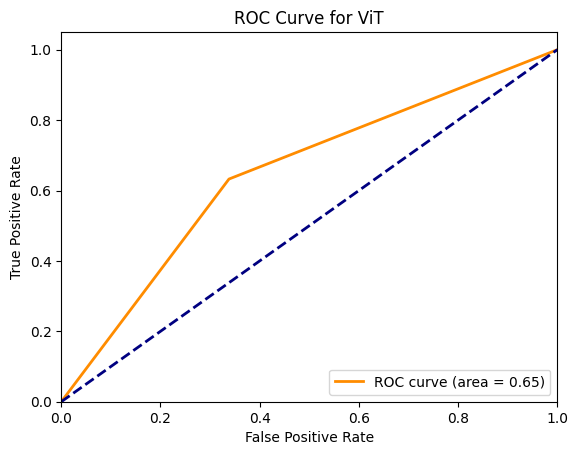

In [65]:
# Plot ROC curve
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for ViT')
plt.legend(loc="lower right")
plt.show()


In [93]:
# save the results
df = pd.DataFrame(columns=['tp', 'tn', 'fp', 'fn', 'fpr', 'tpr', 'thresholds'])
df.loc[0] = [tp, tn, fp, fn, fpr, tpr, thresholds]
df.to_csv('vit_results.csv')